In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.37'

In [3]:
from fastai import *
from fastai_audio import *

In [4]:
import librosa
from utils import read_file
from tqdm import tqdm_notebook as tqdm

In [5]:
DATA = Path('data')
NSYNTH_AUDIO = DATA/'nsynth_audio' # contains train and valid folders

In [6]:
LABEL_DIR = Path('tmp_labels')
GUITAR_TRN = LABEL_DIR/'train_guitar_clean_40_88.csv'
GUITAR_VAL = LABEL_DIR/'valid_guitar_clean_40_88.csv'
GUITAR_TST = LABEL_DIR/'test_guitar_clean_40_88.csv'

In [7]:
trn_df, val_df, tst_df = [pd.read_csv(CSV) for CSV in [GUITAR_TRN, GUITAR_VAL, GUITAR_TST]]
trn_df.head(2)

,note_str,pitch
0,guitar_acoustic_001-082-050,82
1,guitar_electronic_035-062-127,62


In [8]:
len(trn_df), len(val_df), len(tst_df)

(16915, 1112, 347)

In [9]:
sr = 16000

In [10]:
def load_trim_split(df, path, suffix='.wav', max_len=32000, top_db=50, frame_len=1024):
    rows = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        filename = row['note_str'] + '.wav'
        x, _ = read_file(filename, path=path)
        x = x[:max_len]
        x = librosa.effects.trim(x, ref=1.0, top_db=top_db)[0]
        
        n_frames = x.shape[0] // frame_len
        frames = [x[n*frame_len:(n+1)*frame_len] 
                  for n in range(n_frames)]
        
        for frame in frames:
            if frame.shape[0] == frame_len:
                rows.append((row['note_str'], row['pitch'], frame))

    return pd.DataFrame(rows, columns=['note_str', 'pitch', 'frame'])


In [19]:
trn_frames = load_trim_split(trn_df, NSYNTH_AUDIO/'train', max_len=sr*2, frame_len=256)

In [20]:
val_frames = load_trim_split(val_df, NSYNTH_AUDIO/'valid', max_len=sr*2, frame_len=256)

In [21]:
tst_frames = load_trim_split(tst_df, NSYNTH_AUDIO/'test', max_len=sr*2, frame_len=256)

In [22]:
trn_frames.shape, val_frames.shape, tst_frames.shape

((1780167, 3), (129519, 3), (40516, 3))

In [17]:
def save_frames_df(df, name):
    frames_np = np.stack(df['frame'].values)
    np.save(name + '.npy', frames_np)
    df[['note_str', 'pitch']].to_csv(name + '.csv', index=False)
    
def load_frames_df(name):
    df = pd.read_csv(name + '.csv')
    frames_np = np.load(name + '.npy')
    list_frames = np.array_split(frames_np, frames_np.shape[0])
    df['frame'] = pd.Series(map(np.squeeze, list_frames))
    return df

In [23]:
%%time
save_frames_df(trn_frames, 'trn_frames_256')
save_frames_df(val_frames, 'val_frames_256')
save_frames_df(tst_frames, 'tst_frames_256')

CPU times: user 6.26 s, sys: 2.01 s, total: 8.27 s
Wall time: 8.28 s


In [17]:
trn_frames = load_frames_df('trn_frames_1024')
val_frames = load_frames_df('val_frames_1024')
tst_frames = load_frames_df('tst_frames_1024')

CPU times: user 1.67 s, sys: 1.21 s, total: 2.88 s
Wall time: 2.27 s


In [19]:
trn_list = AudioFrameList.from_df(trn_frames, NSYNTH_AUDIO, cols=2)
val_list = AudioFrameList.from_df(val_frames, NSYNTH_AUDIO, cols=2)

In [29]:
trn_frames.iloc[0]['frame'].shape[0]

512

In [20]:
n_fft = trn_frames.iloc[0]['frame'].shape[0]
to_db = ToDecibels(ref=1.0, top_db=50.0)
window = to_device(torch.hann_window(n_fft).unsqueeze_(0), None)

def batch_fft(inputs):
    xs, ys = inputs
    xs = torch.rfft(xs * window, 1, normalized=True).pow_(2.0).sum(-1)
    xs = to_db(xs)
    return xs, ys

batch_tfms = [batch_fft]

In [21]:
bs = 128
data = (ItemLists(NSYNTH_AUDIO, trn_list, val_list)
            .label_from_df('pitch')
            .databunch(bs=bs, tfms=batch_tfms))
xs, ys = data.one_batch()
xs.shape, ys.shape

(torch.Size([128, 513]), torch.Size([128]))

In [22]:
class SimpleModel(nn.Module):
    def __init__(self, n_inputs, n_classes):
        super().__init__()
        self.layers = nn.Sequential(
            *bn_drop_lin(n_inputs, 1024, actn=nn.ReLU(inplace=True), p=0.2),
            *bn_drop_lin(1024, 512, actn=nn.ReLU(inplace=True), p=0.2),
            *bn_drop_lin(512, n_classes, actn=None),
        )
    def forward(self, x):
        return self.layers(x)

In [23]:
model = SimpleModel(513, data.c)
learn = Learner(data, model, metrics=[accuracy])
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          [128, 513]           1026       True      
______________________________________________________________________
Dropout              [128, 513]           0          False     
______________________________________________________________________
Linear               [128, 1024]          526336     True      
______________________________________________________________________
ReLU                 [128, 1024]          0          False     
______________________________________________________________________
BatchNorm1d          [128, 1024]          2048       True      
______________________________________________________________________
Dropout              [128, 1024]          0          False     
______________________________________________________________________
Linear               [128, 512]           524800     True      
______________________________________________________________

In [24]:
model_name = 'pitch_all_frames_v1'
learn.fit_one_cycle(4)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy
1,0.205839,0.011194,0.997258
2,0.159272,0.008146,0.999003
3,0.112693,0.005209,0.998878
4,0.104647,0.004660,0.999065


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


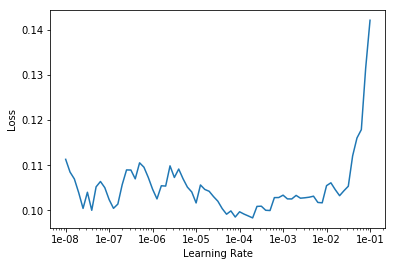

In [25]:
learn.load(model_name + '-stage-1')
learn.lr_find(start_lr=1e-9)
learn.recorder.plot()

In [26]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(16, max_lr=1e-4)
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,accuracy
1,0.096477,0.004587,0.999159
2,0.096061,0.004510,0.999097
3,0.094731,0.004648,0.999159
4,0.095657,0.004470,0.999034
5,0.089923,0.004623,0.998972
6,0.093667,0.004696,0.998878
7,0.094587,0.004655,0.998941
8,0.089777,0.004498,0.999003
9,0.096979,0.004452,0.999034
10,0.089937,0.004466,0.999065


In [27]:
def preds_stats(learner):
    trn_accuracy = float(accuracy(*learner.get_preds(DatasetType.Train)))
    trn_error_rate = 1 - trn_accuracy
    trn_errors = round(len(learner.data.train_ds) * trn_error_rate)
    
    val_accuracy = float(accuracy(*learner.get_preds(DatasetType.Valid)))
    val_error_rate = 1 - val_accuracy
    val_errors = round(len(learner.data.valid_ds) * val_error_rate)
    
    print("Train\n-----")
    print("  accuracy:   {:.4f}".format(trn_accuracy))
    print("  num_errors: {}".format(trn_errors))
    
    
    print("Valid\n-----")
    print("  accuracy:   {:.4f}".format(val_accuracy))
    print("  num_errors: {}".format(val_errors))
    
preds_stats(learn)

Train
-----
  accuracy:   0.9914
  num_errors: 3773
Valid
-----
  accuracy:   0.9990
  num_errors: 31


In [28]:
len(data.train_ds), len(data.valid_ds)

(440752, 32098)

### Raw Audio

In [29]:
bs = 128
data = (ItemLists(NSYNTH_AUDIO, trn_list, val_list)
            .label_from_df('pitch')
            .databunch(bs=bs))
xs, ys = data.one_batch()
xs.shape, ys.shape

(torch.Size([128, 1024]), torch.Size([128]))

In [36]:
class SimpleModel(nn.Module):
    def __init__(self, n_inputs, n_classes):
        super().__init__()
        self.layers = nn.Sequential(
            *bn_drop_lin(n_inputs, 1024, actn=nn.ReLU(inplace=True), p=0.2),
            *bn_drop_lin(1024, 512, actn=nn.ReLU(inplace=True), p=0.2),
            *bn_drop_lin(512, n_classes, actn=None),
        )
    def forward(self, x):
        return self.layers(x)

In [31]:
model = SimpleModel(1024, data.c)
learn = Learner(data, model, metrics=[accuracy])
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          [128, 1024]          2048       True      
______________________________________________________________________
Dropout              [128, 1024]          0          False     
______________________________________________________________________
Linear               [128, 1024]          1049600    True      
______________________________________________________________________
ReLU                 [128, 1024]          0          False     
______________________________________________________________________
BatchNorm1d          [128, 1024]          2048       True      
______________________________________________________________________
Dropout              [128, 1024]          0          False     
______________________________________________________________________
Linear               [128, 512]           524800     True      
______________________________________________________________

In [32]:
model_name = 'pitch_all_frames_raw_v1'
learn.fit_one_cycle(4)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy
1,0.734062,0.241000,0.951025
2,0.551075,0.165304,0.974048
3,0.462866,0.115191,0.986759
4,0.378458,0.118665,0.981899


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


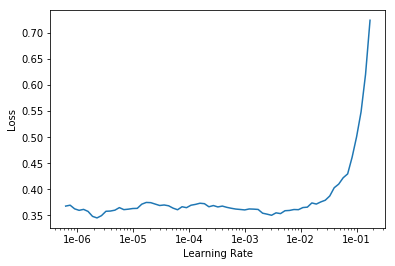

In [33]:
learn.load(model_name + '-stage-1')
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(8, max_lr=1e-3)
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,accuracy
1,0.386701,0.110519,0.983613
2,0.392225,0.112236,0.983893
3,0.407771,0.120536,0.980155
4,0.382427,0.106651,0.982896
5,0.365294,0.118510,0.978192
6,0.351631,0.115238,0.980840
7,0.359213,0.117135,0.977693
8,0.328423,0.106382,0.980933


In [35]:
class SimpleModel2(nn.Module):
    def __init__(self, n_inputs, n_classes):
        super().__init__()
        self.layers = nn.Sequential(
            *bn_drop_lin(n_inputs, 1024, actn=nn.ReLU(inplace=True), p=0.2),
            *bn_drop_lin(1024, 512, actn=nn.ReLU(inplace=True), p=0.2),
            *bn_drop_lin(512, 256, actn=nn.ReLU(inplace=True), p=0.2),
            *bn_drop_lin(256, 128, actn=nn.ReLU(inplace=True), p=0.2),
            *bn_drop_lin(128, n_classes, actn=None),
        )
    def forward(self, x):
        return self.layers(x)

In [36]:
model = SimpleModel2(1024, data.c)
learn = Learner(data, model, metrics=[accuracy])
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          [128, 1024]          2048       True      
______________________________________________________________________
Dropout              [128, 1024]          0          False     
______________________________________________________________________
Linear               [128, 1024]          1049600    True      
______________________________________________________________________
ReLU                 [128, 1024]          0          False     
______________________________________________________________________
BatchNorm1d          [128, 1024]          2048       True      
______________________________________________________________________
Dropout              [128, 1024]          0          False     
______________________________________________________________________
Linear               [128, 512]           524800     True      
______________________________________________________________

In [38]:
model_name = 'pitch_all_frames_raw_v2'
learn.fit_one_cycle(4)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy
1,0.799518,0.202493,0.951648
2,0.568215,0.097520,0.979313
3,0.475158,0.070898,0.986230
4,0.439114,0.048402,0.993302


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


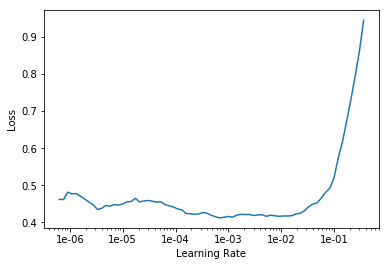

In [39]:
learn.load(model_name + '-stage-1')
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(8, max_lr=1e-3)
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,accuracy
1,0.423010,0.054013,0.989314
2,0.424487,0.058337,0.988722
3,0.406180,0.060121,0.989439
4,0.395791,0.062449,0.987569
5,0.354874,0.057256,0.988878
6,0.374565,0.057378,0.987507
7,0.341129,0.044847,0.993239
8,0.337777,0.043953,0.993208


### 512 samples

In [24]:
trn_frames = load_frames_df('trn_frames_512')
val_frames = load_frames_df('val_frames_512')
tst_frames = load_frames_df('tst_frames_512')

In [32]:
trn_list = AudioFrameList.from_df(trn_frames, NSYNTH_AUDIO, cols=2)
val_list = AudioFrameList.from_df(val_frames, NSYNTH_AUDIO, cols=2)

In [33]:
n_fft = trn_frames.iloc[0]['frame'].shape[0]
to_db = ToDecibels(ref=1.0, top_db=50.0)
window = to_device(torch.hann_window(n_fft).unsqueeze_(0), None)

def batch_fft(inputs):
    xs, ys = inputs
    xs = torch.rfft(xs * window, 1, normalized=True).pow_(2.0).sum(-1)
    xs = to_db(xs)
    return xs, ys

batch_tfms = [batch_fft]

bs = 128
data = (ItemLists(NSYNTH_AUDIO, trn_list, val_list)
            .label_from_df('pitch')
            .databunch(bs=bs, tfms=batch_tfms))
xs, ys = data.one_batch()
xs.shape, ys.shape

(torch.Size([128, 257]), torch.Size([128]))

In [39]:
model = SimpleModel(xs.shape[1], data.c)

model_name = 'pitch_all_frames_512_fft_v1'

learn = Learner(data, model, metrics=[accuracy])
learn.fit_one_cycle(4)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy
1,0.323815,0.043726,0.992129
2,0.222563,0.036247,0.992845
3,0.165639,0.035190,0.994462
4,0.138745,0.029510,0.995365


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


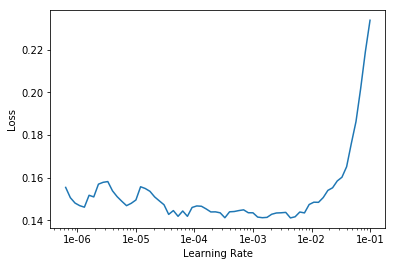

In [40]:
learn.load(model_name + '-stage-1')
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(8, max_lr=1e-3)
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,accuracy
1,0.147136,0.031771,0.995194
2,0.160058,0.036670,0.994665
3,0.148201,0.041126,0.994478
4,0.140783,0.028083,0.995489
5,0.126875,0.030800,0.994960
6,0.118065,0.029264,0.995536
7,0.117536,0.027107,0.995940
8,0.116912,0.027519,0.995971


### Use the model 

In [42]:
filename = 'data/recorded/sunshine_riff.wav'
x, sr = read_file(filename)
x.shape, sr

((143360,), 16000)

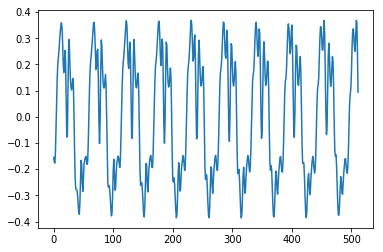

In [46]:
o = 2000
fl = 512
f = x[o:o+fl]
plt.plot(f)

In [48]:
fr = AudioFrame(f)

In [50]:
learn.predict(fr)

(Category 62,
 tensor(22),
 tensor([1.6991e-09, 9.6040e-09, 3.3257e-09, 2.3524e-07, 9.4601e-09, 5.0877e-09,
         3.5207e-10, 3.5882e-10, 1.1082e-09, 3.1433e-09, 8.1173e-04, 7.7391e-09,
         1.2526e-08, 4.0721e-09, 1.2327e-10, 1.7761e-10, 3.7792e-09, 2.0234e-09,
         4.1311e-10, 1.3781e-09, 1.9498e-09, 2.3904e-09, 9.9918e-01, 3.5171e-07,
         9.0846e-06, 1.2083e-08, 1.2366e-09, 1.1568e-09, 1.0858e-09, 8.7919e-09,
         3.1238e-09, 8.4127e-09, 3.7846e-10, 1.2175e-11, 1.8993e-08, 1.4830e-10,
         4.2546e-10, 2.7095e-11, 4.4631e-11, 6.5251e-10, 1.0270e-09, 9.4637e-07,
         1.2140e-09, 4.0352e-10, 2.2725e-11, 7.5703e-10, 4.8953e-11, 2.4715e-10]))

In [51]:
frame_len = 512
n_frames = x.shape[0] // frame_len
frames = [x[n*frame_len:(n+1)*frame_len] for n in range(n_frames)]
len(frames), frames[0].shape

(280, (512,))

In [59]:
%time

preds = []
for frame in frames:
    pred = learn.predict(AudioFrame(frame))[0].obj
    preds.append(pred)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.29 µs


[62, 57, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 61, 60, 60, 60, 60, 60, 60, 60, 60, 60, 62, 62, 62, 62, 62, 62, 62, 62, 75, 62, 62, 62, 62, 62, 62, 62, 62, 57, 57, 57, 57, 57, 57, 57, 57, 40, 57, 57, 57, 57, 57, 57, 57, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 55, 42, 55, 55, 55, 55, 55, 55, 55, 55, 43, 41, 55, 55, 55, 43, 55, 50, 50, 50, 50, 50, 50, 50, 50, 40, 40, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 49, 48, 81, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 60, 60, 60, 60, 60, 60, 60, 60, 60, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 75, 56, 56, 56, 56, 56, 56, 56, 56, 75, 56, 56, 56, 56, 56, 56, 56, 42, 55, 55, 55, 55, 55, 55, 55, 70, 55, 55, 55, 43, 55, 55, 55, 59, 41, 50, 50, 50, 50, 50, 50, 50, 50, 75, 53, 53, 53, 53, 53, 53, 53, 53, 53,

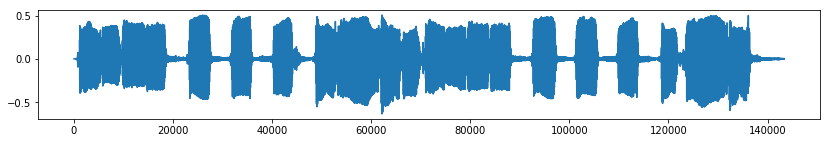

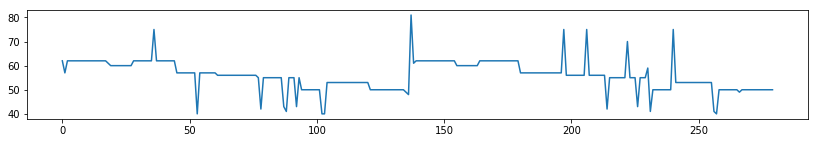

In [68]:
plt.figure(figsize=(14, 2))
plt.plot(x)

plt.figure(figsize=(14, 2))
plt.plot(preds)
print(preds)

In [67]:
from IPython.display import Audio
Audio(x/4, rate=sr)